# Starbucks Capstone Challenge

## Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

*The project goal* is to combine transaction, demographic and offer data to **determine which demographic groups respond best to which offer type**. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

## Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record


# A. Project Deliverables 

1. Identify which groups of people are most responsive to each type of offer  
2. What type offers really excite people?
3. How best to present each type of offer?

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import math
import json
import datetime

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans, OPTICS
from yellowbrick.cluster.elbow import kelbow_visualizer

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix 

import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import warnings

%matplotlib inline
warnings.filterwarnings("ignore")

# D. Modeling

Purpose: Confirm the effectivness of the current user-targeting and promo-offering stratagies used by starbucks

Method: build a predictive model to measure conversion accuracy. Use established metrics as baseline for future A/B testing

## Thought Process

1. Develop a **customer segmentation** model:
    - K-means clustering with elbow an silhouette methods
    - OPTICS method


2. A model to **predict** which customer should receive offers to yield high coversion rate
    - are we giving out the promotional offers to the right audiences that increasing the profit?
    - the 'complete_valid' column indiciates a true converted customer

## D1. Customer Segmentation

In [113]:
customer_promo.head()

,customer_id,gender,age,income,F,M,O,recency,frequency,monetary value,...,received_total,viewed_total,completed_total,email_total,mobile_total,social_total,web_total,recevied_avg,viewed_avg,completed_avg
0,02c083884c7d45b39cc68e1314fec56c,F,20.0,30000.0,1.0,0.0,0.0,18.0,10.0,29.89,...,2.0,1.0,0.0,2.0,1.0,1.0,1.0,1.0,0.5,0.000000
1,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,M,42.0,96000.0,0.0,1.0,0.0,23.0,12.0,320.48,...,4.0,4.0,4.0,4.0,3.0,2.0,4.0,1.0,1.0,1.000000
2,54890f68699049c2a04d415abc25e717,M,36.0,56000.0,0.0,1.0,0.0,29.0,7.0,118.85,...,2.0,2.0,1.0,2.0,2.0,2.0,1.0,1.0,1.0,0.500000
3,b2f1cd155b864803ad8334cdf13c4bd2,F,55.0,94000.0,1.0,0.0,0.0,24.0,8.0,195.35,...,3.0,3.0,1.0,3.0,3.0,2.0,2.0,1.0,1.0,0.333333
4,fe97aa22dd3e48c8b143116a8403dd52,F,39.0,67000.0,1.0,0.0,0.0,30.0,11.0,562.77,...,4.0,4.0,0.0,2.0,2.0,1.0,1.0,2.0,2.0,0.000000


In [114]:
# make the 'customer_id' column as index and drop the 'gender' cols 
# because the scaler can't apply on str
customer_promo.drop(['gender'],axis=1,inplace=True)
customer_promo.set_index('customer_id',inplace=True)

### D1.a. Feature Scaling

In [116]:
scaler = StandardScaler().fit(customer_promo)
customer_promo_scaled = scaler.transform(customer_promo)

### D1.b. Dimensionality Reduction using PCA

In [117]:
# instantiate a PCA object
pca = PCA()
# fit the PCA on the scaled dataset and transform it
X_pca = pca.fit_transform(customer_promo_scaled)

In [118]:
# individual explained variance 
var_exp = pca.explained_variance_ratio_

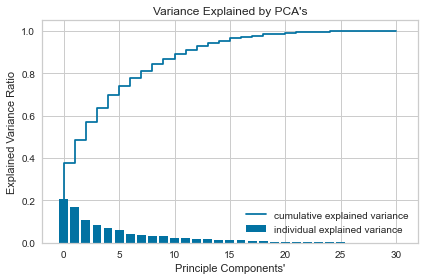

In [119]:
# Plot the explained variance ratios
x = np.arange(len(var_exp))
plt.bar(x, var_exp, label='individual explained variance')
plt.step(x, np.cumsum(var_exp), label='cumulative explained variance')

plt.xlabel("Principle Components'")
plt.ylabel("Explained Variance Ratio")
plt.legend(loc='best')
plt.title("Variance Explained by PCA's")

plt.tight_layout()

**__ Insights __**
- The first 5 components explained about 75% of the variance
- The first 10 components explained about 90% of the variance 
- Starting the 6th to the 10th, I don't observe much variance change. I'm going to choose 80% (about average) variance as the top limit to find the optimal principal components

In [120]:
# cumulative explained variances
cum_var_exp = np.cumsum(var_exp)
# number of components is the size of the matrix where the cumulative sum is <= 80%
n_components = len(cum_var_exp[cum_var_exp<= 0.8])

# reduce the dimensionality with the generated numbers of principle components 
pca = PCA(n_components=n_components).fit(customer_promo_scaled)
# transform the dataset
X_pca = pca.fit_transform(customer_promo_scaled) 

### D1.c. Find the optimal number of clusters

### Using K-means

In [121]:
from yellowbrick.cluster import KElbowVisualizer

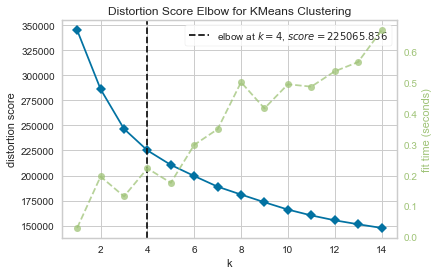

KElbowVisualizer(ax=<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>,
                 estimator=KMeans(n_clusters=14), k=(1, 15))

In [122]:
# elbow method
kelbow_visualizer(KMeans(), X_pca, k=(1,15))

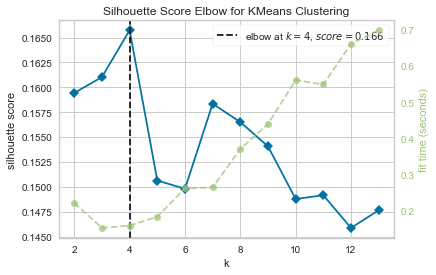

KElbowVisualizer(ax=<AxesSubplot:title={'center':'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>,
                 estimator=KMeans(n_clusters=13), k=(2, 14),
                 metric='silhouette')

In [123]:
# silhouette method
kelbow_visualizer(KMeans(), X_pca, k=(2,14), metric='silhouette')

**__ Foundings __**

Both elbow and silhouette methods result in **cluster = 4**

In [124]:
# instansiate a k-means model with 4 clusters
model = KMeans(n_clusters=4, random_state=28).fit(X_pca)
# predict the cluster each data point belong to
kmeans_clusters = model.predict(X_pca)

In [125]:
kmeans_clusters

array([2, 3, 0, ..., 1, 1, 1], dtype=int32)

### Using OPTICS

In [126]:
# define the model
model = OPTICS(eps = 0.8, min_samples=35)
# fit model and predict clusters
optics_clusters = model.fit_predict(X_pca)
# retrieve unique clusters
clusters = np.unique(optics_clusters)

In [127]:
print('Number of clusters analyzed by OPTICS:', len(clusters))

Number of clusters analyzed by OPTICS: 4


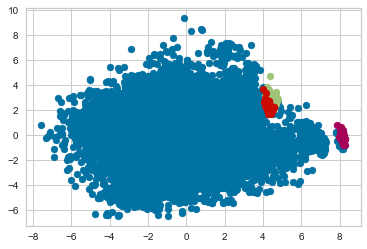

In [128]:
# create scatter plot for samples from each cluster
for cluster in clusters:
    # get row indexes for samples with this cluster
    row_ix = np.where(optics_clusters == cluster)
    # create scatter of these samples
    plt.scatter(X_pca[row_ix, 0], X_pca[row_ix, 1])
# show the plot
plt.show()

<AxesSubplot:ylabel='Count'>

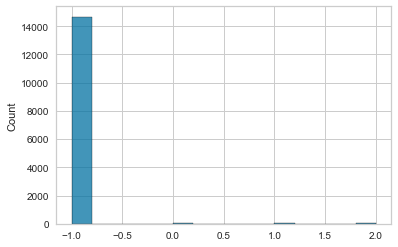

In [129]:
sns.histplot(optics_clusters)

**__ Foundings __**

OPTICS method produces **4 clusters**, but there is a lot of noise (-1)

### D1.d. Evaluate the segmentation

### K-means

In [130]:
cp_kmeans = customer_promo.copy().reset_index()

# create 'cluster' col containing predicted values (aka clusters 1-4) 
cp_kmeans['cluster'] = kmeans_clusters
# drop the 'informational_cr' col since they're all 0s
cp_kmeans.drop(['informational_cr'], axis=1, inplace=True)

cp_kmeans.head()

,customer_id,age,income,F,M,O,recency,frequency,monetary value,informational_vr,...,viewed_total,completed_total,email_total,mobile_total,social_total,web_total,recevied_avg,viewed_avg,completed_avg,cluster
0,02c083884c7d45b39cc68e1314fec56c,20.0,30000.0,1.0,0.0,0.0,18.0,10.0,29.89,0.0,...,1.0,0.0,2.0,1.0,1.0,1.0,1.0,0.5,0.000000,2
1,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,42.0,96000.0,0.0,1.0,0.0,23.0,12.0,320.48,0.0,...,4.0,4.0,4.0,3.0,2.0,4.0,1.0,1.0,1.000000,3
2,54890f68699049c2a04d415abc25e717,36.0,56000.0,0.0,1.0,0.0,29.0,7.0,118.85,1.0,...,2.0,1.0,2.0,2.0,2.0,1.0,1.0,1.0,0.500000,0
3,b2f1cd155b864803ad8334cdf13c4bd2,55.0,94000.0,1.0,0.0,0.0,24.0,8.0,195.35,1.0,...,3.0,1.0,3.0,3.0,2.0,2.0,1.0,1.0,0.333333,0
4,fe97aa22dd3e48c8b143116a8403dd52,39.0,67000.0,1.0,0.0,0.0,30.0,11.0,562.77,1.0,...,4.0,0.0,2.0,2.0,1.0,1.0,2.0,2.0,0.000000,0


In [131]:
cp_kmeans = cp_kmeans.melt(id_vars=['customer_id','cluster'])
cp_kmeans.head()

,customer_id,cluster,variable,value
0,02c083884c7d45b39cc68e1314fec56c,2,age,20.0
1,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,3,age,42.0
2,54890f68699049c2a04d415abc25e717,0,age,36.0
3,b2f1cd155b864803ad8334cdf13c4bd2,0,age,55.0
4,fe97aa22dd3e48c8b143116a8403dd52,0,age,39.0


In [132]:
# What are the clusters
cp_kmeans['cluster'].value_counts()

3    145260
1    125130
2     91620
0     82230
Name: cluster, dtype: int64

In [133]:
cp_kmeans = cp_kmeans.groupby(['cluster','variable']).mean().reset_index()
cp_kmeans

,cluster,variable,value
0,0,F,0.456403
1,0,M,0.523167
2,0,O,0.011310
3,0,age,55.120029
4,0,bogo_cr,0.003101
...,...,...,...
115,3,social_total,2.585915
116,3,total_cr,0.889515
117,3,viewed_avg,1.102657
118,3,viewed_total,4.151384


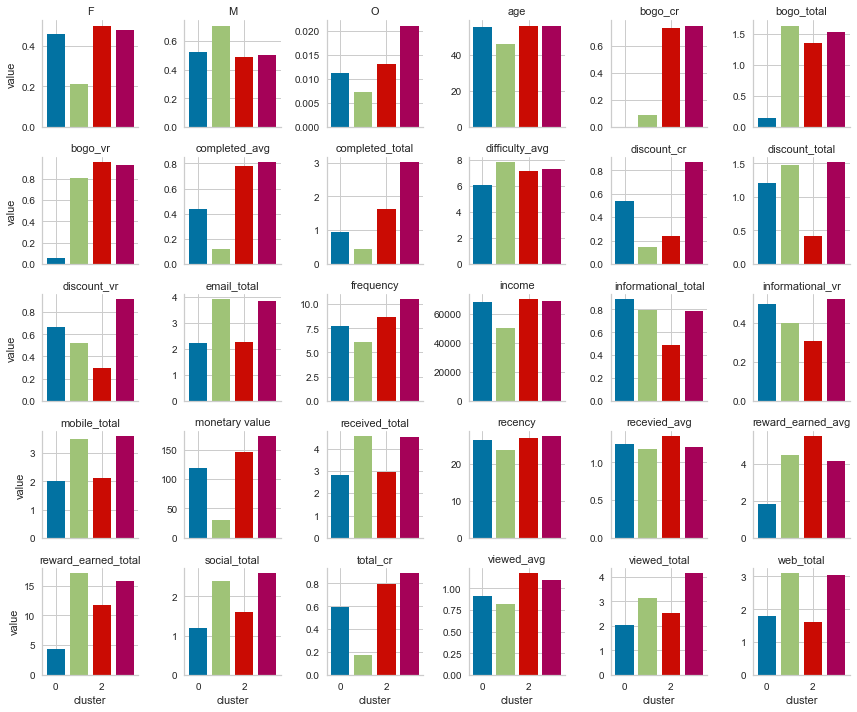

In [134]:
# Graph the groupby dataset above
g_kmeans = sns.FacetGrid(cp_kmeans, col='variable', hue='cluster', col_wrap=6, height=2, sharey=False)
g_kmeans = g_kmeans.map(plt.bar, 'cluster', 'value').set_titles("{col_name}")

### OPTICS

In [135]:
cp_optics = customer_promo.copy().reset_index()

# create 'cluster' col with predicted values
cp_optics['cluster'] = optics_clusters # from section D1.c
cp_optics = cp_optics.melt(id_vars=['customer_id','cluster'])
cp_optics['cluster'].value_counts()

-1    455018
 0      1457
 1      1395
 2      1178
Name: cluster, dtype: int64

In [136]:
cp_optics = cp_optics.query('cluster != -1').groupby(['cluster','variable']).mean().reset_index()
cp_optics.head()

,cluster,variable,value
0,0,F,1.00000
1,0,M,0.00000
2,0,O,0.00000
3,0,age,61.12766
4,0,bogo_cr,0.00000


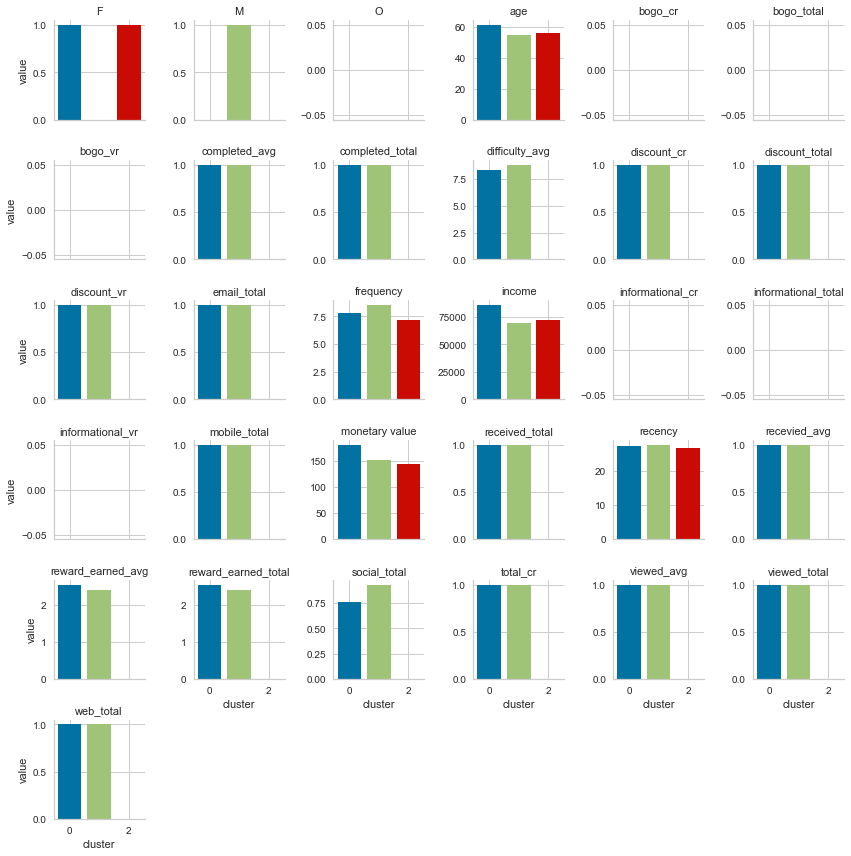

In [137]:
g_optics = sns.FacetGrid(cp_optics, col='variable', hue='cluster', col_wrap=6, height=2, sharey=False)
g_optics = g_optics.map(plt.bar, 'cluster', 'value').set_titles("{col_name}");

### D1.e. Segmentation Conclusions

I'm going to analazye the clusters based on Kmeans method because it produces more distinguished and pronounced clusters than OPTICS. Recall the graphs for followed analysis.

There are four clusters coded in colors: blue, green, red, and purple.

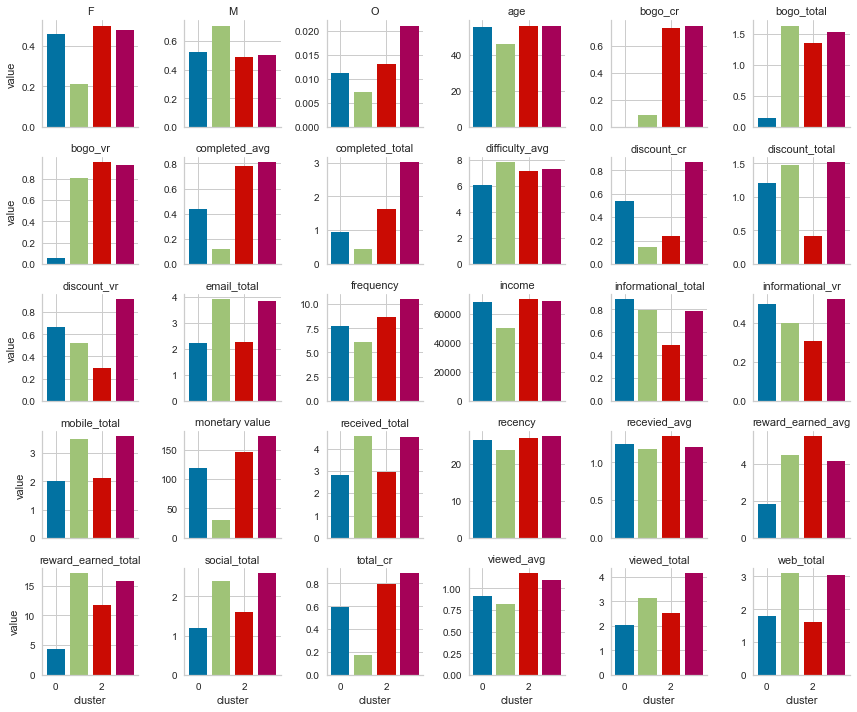

In [138]:
g_kmeans = g_kmeans.map(plt.bar, 'cluster', 'value').set_titles("{col_name}")

### Segment 1 (blue)

Customers in this segment receive **rarely to no BOGO offers**. They recevie *mainly discount offers* and informational ones. Given discount offers received, the customers convey an average convert rate.

This group makes frequent and regular purchases (frequency, monetary value). Thus, either they *can continue to receive some promotional offers or not*. It's likely that they will make purchases at Starbucks regardless.

### Segment 2 (green)

Customers in this segment exhibits a **very low conversion rate but receive offers regularly**. This group receives all 3 promotional offers via all channels. Although their **view rates score slighly high on average**, the completed rates and **total conversion rates are very low**. 

Most customers in this group idetify as **Male and has a lower income on average** compared to the other groups. It is recommended to **stop sending offers** to this group for future campaign. 

### Segment 3 (red)

Customers in this segment receive **mainly BOGO offers and they convert very well**. This group receive BOGO offers regularly and higher than average, but lower in discount offers. Their completed rate on BOGO offers and total conversion rate are high (total_cr). Although the data showed that the level of marketing reachout is only average (mobile, web, and social), this group is very interactive to the received offers. 

The demographic of this group consits of **female and male identified** with average age and income similarly to the other three groups. It's recommended to **target this group** with *more BOGO* offers  


### Segment 4 (purple)

Customers in this segment **oftenly receive offers and they convert very well**. They receive all promotinal offer types (BOGO, discount, and informational) via all channels. 

It's observed that this group on average viewed and completed that offers higher than other groups (viewed_total, completed_total), which results in **very high conversion rates** for both discount and BOGO (discount_cr, bogo_cr, total_cr). It seems like customers in this group are *more receptive to discount* than bogo and they also frequently make purchases (frequency). 

The attributes of this group are **genders identified as Female and Male** with similar age and income compared to the average of the other segments. This group should continue to **be the target** of the promotional stategy.  

In [139]:
# copy the original dataset because the cp_kmeans is a groupby table
c_segments = customer_promo.copy().reset_index()
c_segments['cluster'] = kmeans_clusters
c_segments = c_segments.melt(id_vars=['customer_id','cluster'])

[Text(0.5, 1.0, 'Customers Count in each Clusters')]

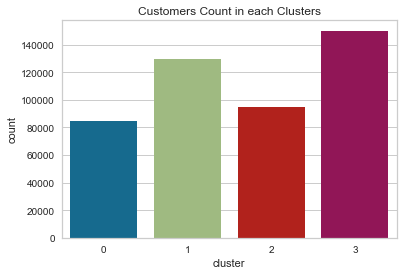

In [140]:
sns.countplot(c_segments['cluster']).set(title='Customers Count in each Clusters')

## D2. Predictive Model

I'm going to use the following classification models:

- Logistic Regression
- KNN
- Random Forest

### Evaluate the important metrics

Since it costs money to send out the promotional offers, I want to focus on **accuracy and precision**. 

Based on the current clusters (see graph above), it looks like there are a significant amount of customers that receive offers but never convert. Thus, I want to stop sending out offers to this pool, which means **minimize** the wrongly predicted converted-customers (**FP**) 

[Text(0.5, 1.0, 'Total Conversion Rate Distribution')]

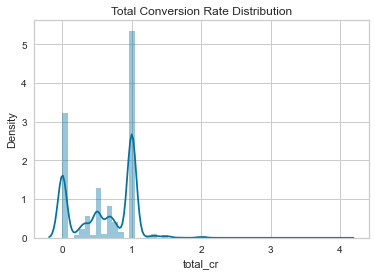

In [141]:
sns.distplot(customer_promo['total_cr']).set(title='Total Conversion Rate Distribution')

[Text(0.5, 1.0, 'Conversion Labels')]

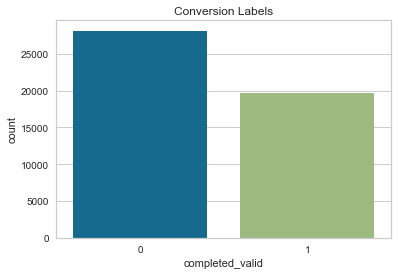

In [142]:
sns.countplot(offers_simp['completed_valid']).set(title='Conversion Labels')

In [143]:
offers_simp.head()

,customer_id,offer_id,day,gender,age,became_member_on,income,F,M,O,...,informational,offer completed,offer received,offer viewed,received_time,viewed_time,completed_time,due_time,viewed_valid,completed_valid
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,16.5,M,33,2017-04-21,72000.0,0,1,0,...,1,0,1,1,14.5,16.5,0.0,18.5,1,0
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,8.5,M,33,2017-04-21,72000.0,0,1,0,...,1,0,1,1,7.5,8.5,0.0,10.5,1,0
5,0011e0d4e6b944f998e987f904e8c1e5,0b1e1539f2cc45b7b9fa7c272da2e1d7,24.5,O,40,2018-01-09,57000.0,0,0,1,...,0,1,1,1,17.5,18.5,24.5,27.5,1,1
6,0011e0d4e6b944f998e987f904e8c1e5,2298d6c36e964ae4a3e7e9706d1fb8c2,11.5,O,40,2018-01-09,57000.0,0,0,1,...,0,1,1,1,7.5,8.5,11.5,14.5,1,1
7,0011e0d4e6b944f998e987f904e8c1e5,3f207df678b143eea3cee63160fa8bed,1.5,O,40,2018-01-09,57000.0,0,0,1,...,1,0,1,1,0.5,1.5,0.0,4.5,1,0


**Note**
- use offers_simp df for creating predictive model
- remove informational offers because they don't convert customers
- remove unnecessary columns

In [144]:
offers_simp.columns

Index(['customer_id', 'offer_id', 'day', 'gender', 'age', 'became_member_on',
       'income', 'F', 'M', 'O', 'reward', 'difficulty', 'duration',
       'offer_type', 'channel_email', 'channel_mobile', 'channel_social',
       'channel_web', 'bogo', 'discount', 'informational', 'offer completed',
       'offer received', 'offer viewed', 'received_time', 'viewed_time',
       'completed_time', 'due_time', 'viewed_valid', 'completed_valid'],
      dtype='object')

In [145]:
promo = offers_simp.copy()

# Remove unnecessary information
promo.drop(['customer_id', 'offer_id', 'day', 'gender', 'age', 'became_member_on', 'offer_type', 
            'offer completed','offer received', 'offer viewed', 'received_time', 'viewed_time', 'completed_time', 
            'due_time', 'viewed_valid', 'channel_email'], axis=1, inplace=True)
promo.head()

,income,F,M,O,reward,difficulty,duration,channel_mobile,channel_social,channel_web,bogo,discount,informational,completed_valid
1,72000.0,0,1,0,0,0,4,1,0,1,0,0,1,0
2,72000.0,0,1,0,0,0,3,1,1,0,0,0,1,0
5,57000.0,0,0,1,5,20,10,0,0,1,0,1,0,1
6,57000.0,0,0,1,3,7,7,1,1,1,0,1,0,1
7,57000.0,0,0,1,0,0,4,1,0,1,0,0,1,0


In [146]:
promo.corr()['completed_valid'].sort_values(ascending=False)

completed_valid    1.000000
duration           0.331297
discount           0.255206
difficulty         0.246160
reward             0.204958
channel_social     0.204233
channel_web        0.203413
income             0.169726
bogo               0.141311
F                  0.113899
channel_mobile     0.063957
O                  0.021396
M                 -0.118454
informational     -0.457464
Name: completed_valid, dtype: float64

<AxesSubplot:>

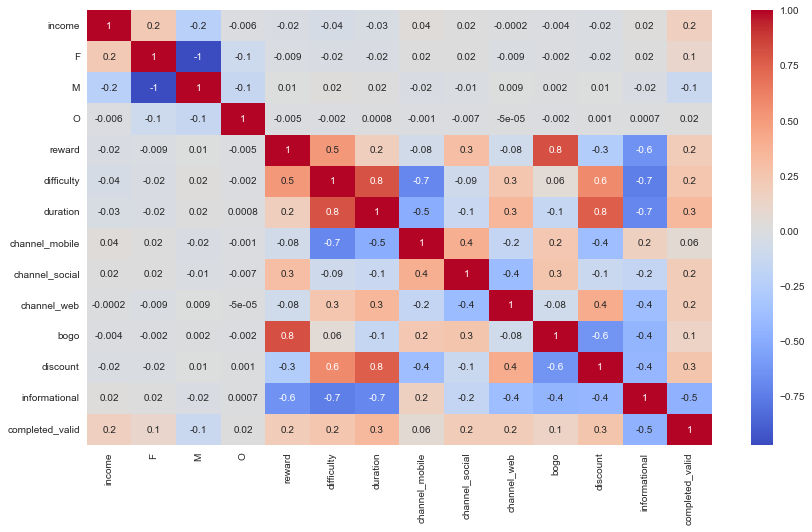

In [147]:
plt.figure(figsize=(14,8))
sns.heatmap(promo.corr(),annot=True, cmap='coolwarm',fmt='.1g')

**__ Insights __**

Compared to the previous Pearson correlation analysis, factors that positively correlated with customer converted stay the same. The top factors are the **offers' attributes**: promotions' duration, difficulty, amount reward, and advertisement platform. Customers are more likely to utilize **discounts** than BOGO. 

### D2.a. Train - Test Split

In [148]:
X = promo.drop('completed_valid',axis=1)
y = promo['completed_valid']

In [149]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### D2.b. Tuning Parameters

#### KNN

In [150]:
k_range = range(1,41)
param_grid_knn = dict(n_neighbors=k_range)

for k in k_range:
    grid_knn = GridSearchCV(KNeighborsClassifier(n_neighbors=k), param_grid_knn, cv=10,scoring='accuracy')

In [151]:
grid_knn.fit(X_train,y_train)

GridSearchCV(cv=10, estimator=KNeighborsClassifier(n_neighbors=40),
             param_grid={'n_neighbors': range(1, 41)}, scoring='accuracy')

In [152]:
grid_knn.best_params_

{'n_neighbors': 31}

### D2.c. Train the models

In [153]:
# instantiate and fit the models on the training set
log = LogisticRegression().fit(X_train, y_train)
knn = KNeighborsClassifier(n_neighbors=31).fit(X_train, y_train)
rfc = RandomForestClassifier().fit(X_train, y_train)

In [154]:
models = [log, knn, rfc]
models_names = ['Logistic Regression', 'KNN', 'Random Forest']

In [155]:
scoring = ['accuracy','precision','recall']
train_accuracy = []
train_precision = []
train_recall = []
train_std = []

train_scoring = {}
for i,model in enumerate (models):
    scores = cross_validate(model, X_train, y_train, cv=10, scoring=scoring)
    train_accuracy.append(scores['test_accuracy'].mean())
    train_precision.append(scores['test_precision'].mean())
    train_recall.append(scores['test_recall'].mean())
    train_std.append(scores['test_accuracy'].std())
    
    train_scoring[i] = scores['test_accuracy'] # for graphing purpose below

In [156]:
train_scores = pd.DataFrame(list(zip(train_accuracy,train_precision,train_recall,train_std)),
                            index=models_names,columns=['Accuracy','Precision','Recall','Standard Deviation'])
print('Models Training Scores')
train_scores

Models Training Scores


,Accuracy,Precision,Recall,Standard Deviation
Logistic Regression,0.589754,0.000000,0.000000,0.000107
KNN,0.737267,0.664789,0.725406,0.006744
Random Forest,0.729649,0.658152,0.709751,0.007135


### D2.d. Compare the models

Text(0, 0.5, 'Accuracy rate')

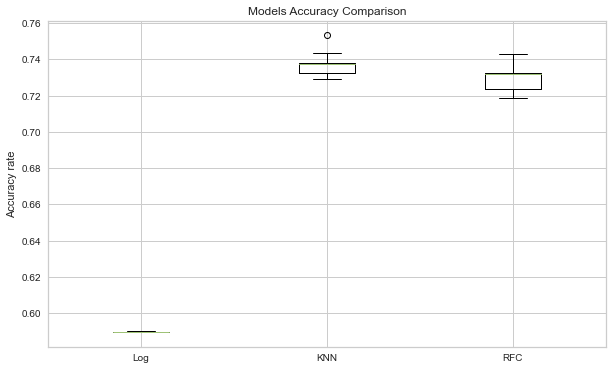

In [157]:
fig, ax = plt.subplots(figsize=(10,6))
ax.boxplot(train_scoring.values())
ax.set_xticklabels(['Log','KNN','RFC'])

plt.title('Models Accuracy Comparison')
plt.ylabel('Accuracy rate')

**__ Insights __**

Logistic Regression model produces 0.0 scores on precision and recall. This inidicates that this model can't predict 1's label due to imbalanced data. It could have been trained with dominant 0's label. 

KNN model achieves the high scores in all the metrics, followed by RFC

### D2.e. Test the Models

In [158]:
accuracy_scores = []
precision_scores = []
recall_scores = []
error_rate = []

for i,model in enumerate (models):
    y_pred = model.predict(X_test)
    conf_matrix = confusion_matrix(y_test,y_pred)
    
    print('\n')
    print(models_names[i])
    print(classification_report(y_test,y_pred))
    '\n'
    print(conf_matrix)
    
    tn = conf_matrix[0,0]
    fp = conf_matrix[0,1]
    tp = conf_matrix[1,1]
    fn = conf_matrix[1,0]
    
    total = tn + fp + tp + fn

    accuracy  = (tp + tn) / total # Accuracy Rate
    precision = tp / (tp + fp) # Positive Predictive Value
    recall    = tp / (tp + fn) # True Positive Rate
    error = (fp + fn) / total # Missclassification Rate
 
    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)
    error_rate.append(error)



Logistic Regression
              precision    recall  f1-score   support

           0       0.59      1.00      0.74      8418
           1       0.00      0.00      0.00      5929

    accuracy                           0.59     14347
   macro avg       0.29      0.50      0.37     14347
weighted avg       0.34      0.59      0.43     14347

[[8418    0]
 [5929    0]]


KNN
              precision    recall  f1-score   support

           0       0.79      0.76      0.77      8418
           1       0.67      0.71      0.69      5929

    accuracy                           0.74     14347
   macro avg       0.73      0.73      0.73     14347
weighted avg       0.74      0.74      0.74     14347

[[6369 2049]
 [1728 4201]]


Random Forest
              precision    recall  f1-score   support

           0       0.79      0.75      0.77      8418
           1       0.67      0.71      0.69      5929

    accuracy                           0.73     14347
   macro avg       0.73      0

In [159]:
scores_df = pd.DataFrame(list(zip(accuracy_scores,precision_scores,recall_scores,error_rate)),index=models_names,columns=['Accuracy','Precision','Recall','Error Rate'])
print('Models Evaluation from Test Set')
scores_df

Models Evaluation from Test Set


,Accuracy,Precision,Recall,Error Rate
Logistic Regression,0.586743,NaN,0.000000,0.413257
KNN,0.736739,0.672160,0.708551,0.263261
Random Forest,0.734788,0.668947,0.709226,0.265212


### D2.f. Conclusion

KNN performs best on this dataset with high accuracy and precision scores, and the smaller error rate compared to Random Forest.

# E. Conclusion and Discussion

At a high level, purchases made during this promotion period carry some charactersistics:
- Customers are more receptive to discounts and BOGOs
- Male are hihgly interactive with offers (receive, view, and complete). They are also the customers that currently receive more offers compared to other genders (female, other, unspecified)
- Most amount spent is up to 200 USD
- Amount spent is in correlation with customers' incomes. 

## Offer personalization

Based on the segmentation analysis, **4 groups of customers** were identified. Three (3) clusters convert well and make regular purchases.

**Receive offers regularly**: 
- convert very well
- is also currently the target audience to receive many offers compared to other genders in all age group
- male and female identified

**Receive BOGOs**:
- convert very well
- mainly receive BOGOs offers and utilize them
- male and female identified

**Don't receive BOGOs at all, but mainly discounts**
- rarely receive any BOGOs
- make frequent purchases with or without offers

**Receive many offers but don't convert**
- frequently receive offers but never open nor complete
- mainly male

We can continue to send out offers that are **discount and BOGO** since they drive customers' buying decisions. The reward value also excite customers.

The source of offers that highly correlates with conversion rate are **social and website**. Here is the cue that we should focus on optimizing the presentation of offers on Starbucks social platform and homepage.

## How effective are the offers?

Currently, purchase usually comes from Discount then BOGO 
- current converion rate is 21.8%**
- view rate is 33.5%
    
However, the offers are significantly spent on one wrong audience, whom don't interact with the offers. This group is the second large in size of this test. The KNN predictve model produces an accuracy scores of about 73% on both train and validation data sets. This indicates that the model is effective enough to predict the conversion of customers who receive offers.

## Next steps

More sophisticated strategies could be employed to achieve a higher conversion rate among Starbucks customers. Uplift modeling can be used to identify the right customer group for a specific promotion. The uplift model method of "two classifiers" can be used. The process will consist of two steps: 

1. Conduct a randomized A/B test, in which the treatment group of customers receives and offers and the control group does not. Train classifiers to predict the likelihood (probability) of conversion for both groups. Add two classifiers into one using a special library (upliftML , casualML). Use a combined classifier on the entire customer base to identify customers with high conversion probability.
2. Conduct a second A/B test, in which the treatment group is customers with a high conversion probability receive promo offers and the control group consisting of random customers also receive promo offers. Calculate lift as the difference in total conversion or total amount spent. 

This method allows for more quantitative customer segmentation and promo offerings, rather than qualitative, human-decision-based strategies.   



# References

- Udacity Data Science Capstone project
- Starbucks